## Calculating bit error rate of PDSCH communication
This notebook shows how to calculate the bit error rate of PDSCH communication when there is no channel coding.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

from neoradium import Carrier, PDSCH, CdlChannel, AntennaPanel, Grid, random
from neoradium.utils import toLinear


Simulating end-to-end for "16QAM", with "Perfect" channel estimation, in time domain.
SNR(dB)   Total Bits   Bit Errors   BER(%)   time(Sec.)
-------   ----------   ----------   ------   ----------
    0       2545920       707059     27.77     18.15
    5       2545920       447088     17.56     18.07
   10       2545920       231451      9.09     18.11
   15       2545920        84791      3.33     18.21
   20       2545920         7757      0.30     18.02
   25       2545920           18      0.00     18.30

Simulating end-to-end for "16QAM", with "LS" channel estimation, in time domain.
SNR(dB)   Total Bits   Bit Errors   BER(%)   time(Sec.)
-------   ----------   ----------   ------   ----------
    0       2545920       865111     33.98     18.49
    5       2545920       594020     23.33     18.21
   10       2545920       331367     13.02     18.26
   15       2545920       147727      5.80     18.30
   20       2545920        30502      1.20     18.31
   25       2545920     

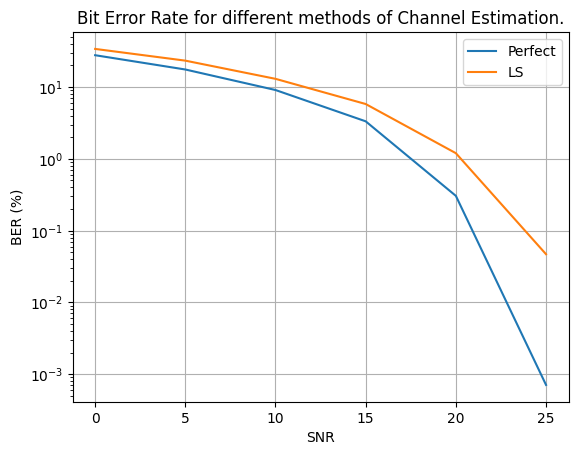

In [7]:
numFrames = 2                               # Number of time-domain frames
snrDbs = [0,5,10,15,20,25]                  # SNR values (in dB) for which we want to evaluate the model
freqDomain = False                          # Set to True to apply channel in frequency domain

modulation = "16QAM"                        # Modulation Scheme
carrier = Carrier(numRbs=51, spacing=30)    # Create a carrier with 51 RBs and 30KHz subcarrier spacing
bwp = carrier.curBwp                        # The only bandwidth part in the carrier

# Create a PDSCH object
pdsch = PDSCH(bwp, interleavingBundleSize=0, numLayers=2, nID=carrier.cellId, modulation=modulation)
pdsch.setDMRS(prgSize=0, configType=2, additionalPos=2)     # Specify the DMRS configuration

numSlots = bwp.slotsPerFrame*numFrames                      # Total number of slots
results = {}                                                # Dictionary to save the results

minMse, maxMse = 100, 0
for chanEstMethod in ["Perfect", "LS"]:                     # Three different channel estimation methods
    results[chanEstMethod] = {}
    print("\nSimulating end-to-end for \"%s\", with \"%s\" channel estimation, in %s domain."%
          (modulation, chanEstMethod, "frequency" if freqDomain else "time"))
    print("SNR(dB)   Total Bits   Bit Errors   BER(%)   time(Sec.)")
    print("-------   ----------   ----------   ------   ----------")
    for snrDb in snrDbs:
        random.setSeed(123)                          # Making the results reproducible.
        t0 = time.time()
        carrier.slotNo = 0

        # Creating a CdlChannel object:
        channel = CdlChannel(bwp, 'C', delaySpread=300, carrierFreq=4e9, dopplerShift=5,
                             txAntenna = AntennaPanel([2,4], polarization="x"),  # 16 TX antenna
                             rxAntenna = AntennaPanel([1,2], polarization="x"))  # 4 RX antenna

        bitErrors = 0
        totalBits = 0

        for slotNo in range(numSlots):
            grid = pdsch.getGrid()                       # Create a resource grid already populated with DMRS 
            numBits = pdsch.getBitSizes(grid)[0]         # Actual number of bits available in the resource grid
            txBits = random.bits(numBits)                # Create random binary data

            # Now populate the resource grid with coded data. This includes QAM modulation and resource mapping.
            pdsch.populateGrid(grid, txBits)

            # Store the indexes of the PDSCH data in pdschIndexes to be used later.
            pdschIndexes = pdsch.getReIndexes(grid, "PDSCH")   

            # Getting the Precoding Matrix, and precoding the resource grid
            channelMatrix = channel.getChannelMatrix()              # Get the channel matrix
            precoder = pdsch.getPrecodingMatrix(channelMatrix)      # Get the precoder matrix from PDSCH object
            precodedGrid = grid.precode(precoder)                   # Perform the precoding

            if freqDomain:
                rxGrid = precodedGrid.applyChannel(channelMatrix)           # Apply the channel in frequency domain
                rxGrid = rxGrid.addNoise(snrDb=snrDb, useRxPower=True)      # Add noise
            else:
                txWaveform = precodedGrid.ofdmModulate()                    # OFDM Modulation
                maxDelay = channel.getMaxDelay()                            # Get the max. channel delay
                txWaveform = txWaveform.pad(maxDelay)                       # Pad with zeros
                rxWaveform = channel.applyToSignal(txWaveform)              # Apply channel in time domain
                noisyRxWaveform = rxWaveform.addNoise(snrDb=snrDb, bwp=bwp, useRxPower=True) # Add noise
                offset = channel.getTimingOffset()                          # Get timing info for synchronization
                syncedWaveform = noisyRxWaveform.sync(offset)               # Synchronization
                rxGrid = syncedWaveform.ofdmDemodulate(bwp)                 # OFDM demodulation

            if chanEstMethod == "Perfect":                          # Perfect Channel Estimation
                estChannelMatrix = channelMatrix @ precoder[None,...]
            else:                                                   # LS + Interpolation Channel Estimation
                estChannelMatrix, noiseEst = rxGrid.estimateChannelLS(pdsch.dmrs, polarInt=False, 
                                                                      kernel='linear')
            act = channelMatrix @ precoder[None,...]
            mse1 = np.square(np.abs(estChannelMatrix - act)).mean()
            fEst = np.stack([estChannelMatrix.real, estChannelMatrix.imag], axis=4)
            fAct = np.stack([act.real, act.imag], axis=4)
            mse2 = np.square(fEst - fAct).mean()
            if minMse>mse2: minMse=mse2
            if maxMse<mse2: maxMse=mse2

            eqGrid, llrScales = rxGrid.equalize(estChannelMatrix)       # Equalization
            rxBits = pdsch.getHardBitsFromGrid(eqGrid, pdschIndexes)[0] # Demodulation
            bitErrors += np.abs(rxBits-txBits).sum()                    # Calculating number of bit errors
            totalBits += numBits
            print("\r  %3d      %8d     %8d    %6.2f    %6.2f"%(snrDb, totalBits, bitErrors, 
                                                                bitErrors*100/totalBits, time.time()-t0), end='')

            channel.goNext()                        # Prepare the channel model for the next slot

        dt = time.time()-t0                         # Total time for this SNR
        results[chanEstMethod][snrDb] = {"totalBits":totalBits, 
                                         "bitErrors":bitErrors, 
                                         "BER":      bitErrors*100/totalBits,
                                         "Time":     dt,
                                         "NoiseVar": rxGrid.noiseVar}
        print("\r  %3d      %8d     %8d    %6.2f    %6.2f"%(snrDb, totalBits, bitErrors, 
                                                            bitErrors*100/totalBits, dt))

# Compare the results in a plot:
for i,chanEstMethod in enumerate(["Perfect", "LS"]):
    bers = [results[chanEstMethod][snrDb]["BER"] for snrDb in snrDbs]
    plt.plot(snrDbs, bers, label=chanEstMethod)
plt.legend()
plt.title("Bit Error Rate for different methods of Channel Estimation.");
plt.grid()
plt.xlabel("SNR")
plt.xticks(snrDbs)
plt.ylabel("BER (%)")
plt.yscale('log')
plt.show()